In [ ]:
from scipy.signal import detrend
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

CSV_PATH = "/home/theion/note/ei-data/task/task3/task3.csv"

df = pd.read_csv(CSV_PATH, header=None)
df.index = pd.Index(range(df.shape[0]), name="depth_m")
df.columns = pd.Index(range(df.shape[1]), name="time_min")

In [5]:
def heat_plot(df):
    plt.imshow(df, aspect='auto', cmap='seismic')
    plt.colorbar()
    plt.title("Raw DAS Data")
    plt.show()
    plt.clf()
##

In [3]:
def space_plot(data):
    if isinstance(data, np.ndarray):
        Z = data
        x = np.arange(Z.shape[1])
        y = np.arange(Z.shape[0])
    else:
        Z = data.to_numpy()
        x = np.asarray(data.columns)
        y = np.asarray(data.index)

    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="seismic", linewidth=0, antialiased=True)

    ax.set_title("3D Surface of DAS Data")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Depth (m)")
    ax.set_zlabel("Amplitude")
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label="Amplitude")

    plt.show()
    plt.close(fig)

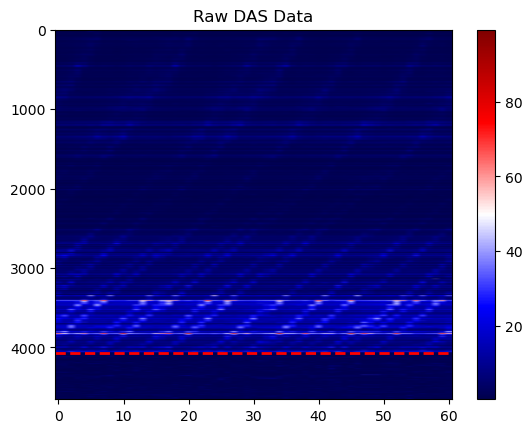

<Figure size 640x480 with 0 Axes>

In [6]:
plt.axhline(4065, color='r', linestyle='--', linewidth=2)
heat_plot(df)
# NOTE:  There is almost no patter so below `4065` so remove it

df = df.iloc[:4065, ]

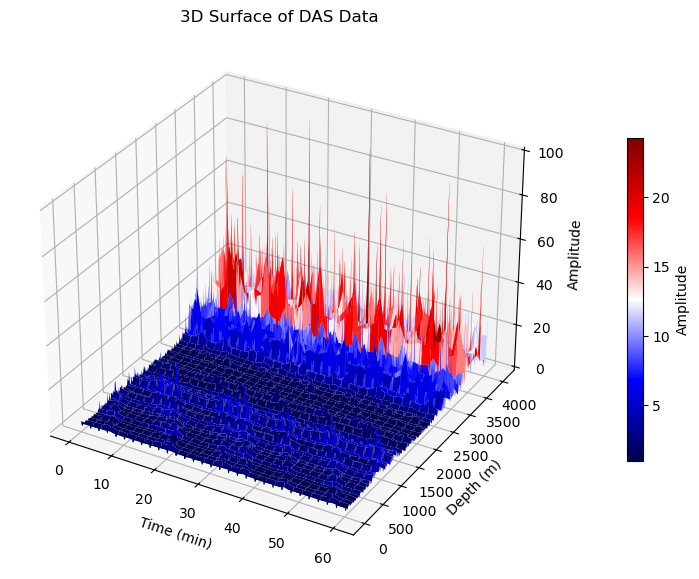

In [7]:
space_plot(df)
# NOTE: Distribution is not normalized and as we go down the the signal gets stronger

In [8]:
def normalize(data, method="row_zscore"):
    x = data.to_numpy(dtype=float) if hasattr(data, "to_numpy") else np.asarray(data, dtype=float)

    def zscore(a, axis):
        mu = np.mean(a, axis=axis, keepdims=True)
        sd = np.std(a, axis=axis, keepdims=True)
        sd = np.where(sd == 0, 1.0, sd)
        return (a - mu) / sd

    if method == "minmax":
        return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-12)
    if method == "global_zscore":
        return zscore(x, axis=None)
    if method == "row_zscore":
        return zscore(x, axis=1)
    if method == "col_zscore":
        return zscore(x, axis=0)
    if method == "detrend_row_zscore":
        return zscore(detrend(x, axis=1), axis=1)

    raise ValueError(f"Unknown normalization method: {method}")

In [9]:
def noise_reduction(data, method="gaussian", **kwargs):
    x = data.to_numpy(dtype=float) if hasattr(data, "to_numpy") else np.asarray(data, dtype=float)

    if method == "gaussian":
        from scipy.ndimage import gaussian_filter
        return gaussian_filter(x, sigma=kwargs.get("sigma", (1, 1)))

    if method == "median":
        from scipy.ndimage import median_filter
        return median_filter(x, size=kwargs.get("size", (3, 3)))

    if method == "detrend":
        from scipy.signal import detrend as _detrend
        return _detrend(x, axis=kwargs.get("axis", 1))

    if method == "gaussian_detrend":
        from scipy.signal import detrend as _detrend
        from scipy.ndimage import gaussian_filter
        x2 = _detrend(x, axis=1)
        return gaussian_filter(x2, sigma=kwargs.get("sigma", (1, 1)))

    raise ValueError(f"Unknown noise reduction method: {method}")

In [10]:
def edge_detection(data, method="sobel", **kwargs):
    x = data.to_numpy(dtype=float) if hasattr(data, "to_numpy") else np.asarray(data, dtype=float)

    if method == "sobel":
        from scipy.ndimage import sobel
        gx = sobel(x, axis=1)
        gy = sobel(x, axis=0)
        return np.hypot(gx, gy)

    if method == "prewitt":
        from scipy.ndimage import prewitt
        gx = prewitt(x, axis=1)
        gy = prewitt(x, axis=0)
        return np.hypot(gx, gy)

    if method == "laplacian":
        from scipy.ndimage import laplace
        return np.abs(laplace(x))

    if method == "canny":
        from skimage.feature import canny
        return canny(x, sigma=kwargs.get("sigma", 2))

    raise ValueError(f"Unknown edge detection method: {method}")

In [ ]:
NORMALIZE_METHODS = [
    "minmax",
    "global_zscore",
    "row_zscore",
    "col_zscore",
    "detrend_row_zscore",
]

NOISE_METHODS = [
    "gaussian",
    "median",
    "detrend",
    "gaussian_detrend",
]

EDGE_METHODS = [
    "sobel",
    "prewitt",
    "laplacian",
    "canny",
]

def run_all_combinations(
    df,
    normalize_methods=NORMALIZE_METHODS,
    noise_methods=NOISE_METHODS,
    edge_methods=EDGE_METHODS,
    # optional per-method parameters:
    gaussian_sigma=(1, 1),
    median_size=(3, 3),
    canny_sigma=2,
    detrend_axis=1,
):
    results = {}  # key: (norm, noise, edge) -> output (numpy array or bool array for canny)

    for n_method in normalize_methods:
        x1 = normalize(df, method=n_method)

        for nr_method in noise_methods:
            if nr_method == "gaussian":
                x2 = noise_reduction(x1, method=nr_method, sigma=gaussian_sigma)
            elif nr_method == "median":
                x2 = noise_reduction(x1, method=nr_method, size=median_size)
            elif nr_method == "detrend":
                x2 = noise_reduction(x1, method=nr_method, axis=detrend_axis)
            elif nr_method == "gaussian_detrend":
                x2 = noise_reduction(x1, method=nr_method, sigma=gaussian_sigma)
            else:
                raise ValueError(f"Unexpected noise method: {nr_method}")

            for e_method in edge_methods:
                if e_method == "canny":
                    x3 = edge_detection(x2, method=e_method, sigma=canny_sigma)
                else:
                    x3 = edge_detection(x2, method=e_method)

                results[(n_method, nr_method, e_method)] = x3

    return results


results = run_all_combinations(df)

heat_plot(results[("row_zscore", "gaussian", "sobel")])

array([[0.41212368, 2.23959696, 3.86794458, ..., 0.98193126, 1.36397858,
        0.20701686],
       [0.56817203, 2.14717993, 3.79927932, ..., 1.0916251 , 1.36360159,
        0.20990699],
       [0.58430221, 2.04913947, 3.75245384, ..., 1.24997253, 1.4156708 ,
        0.3847905 ],
       ...,
       [2.04512085, 5.12050488, 4.63131831, ..., 2.51769759, 1.40203612,
        1.25981882],
       [1.81787387, 4.51590117, 4.27605706, ..., 3.13648958, 1.09641973,
        1.04542863],
       [1.56446621, 3.96748585, 3.78560565, ..., 3.19973944, 0.51554756,
        0.7935549 ]], shape=(4065, 61))

In [ ]:
def _hough_lines(img, *, theta=None, num_peaks=10, peak_threshold=None, threshold=None):

    x = img.to_numpy(dtype=float) if hasattr(img, "to_numpy") else np.asarray(img, dtype=float)

    if x.dtype != bool:
        thr = threshold if threshold is not None else np.percentile(np.abs(x), 95)
        x_bin = (np.abs(x) >= thr)
    else:
        x_bin = x

    if theta is None:
        theta = np.linspace(-np.pi / 2, np.pi / 2, 360)

    h, angles, dists = hough_line(x_bin, theta=theta)
    accums, thetas, rhos = hough_line_peaks(
        h, angles, dists,
        num_peaks=int(num_peaks),
        threshold=peak_threshold,
    )

    lines = []
    for a, t, r in zip(accums, thetas, rhos):
        slope = -(np.cos(t) / (np.sin(t) + 1e-12))  # rows/cols
        lines.append({
            "method": "hough",
            "params": {"theta": float(t), "rho": float(r)},
            "score": float(a),
            "slope_dt": float(slope),
        })
    return lines

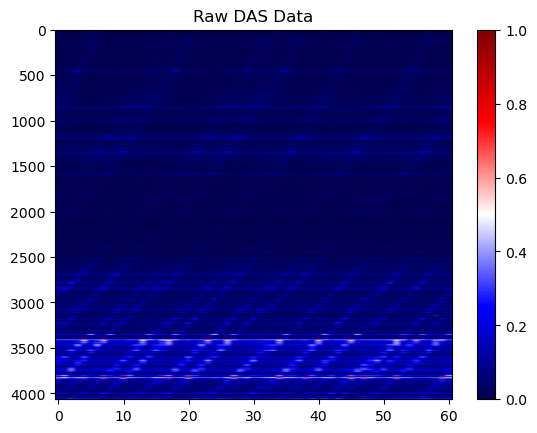

<Figure size 640x480 with 0 Axes>

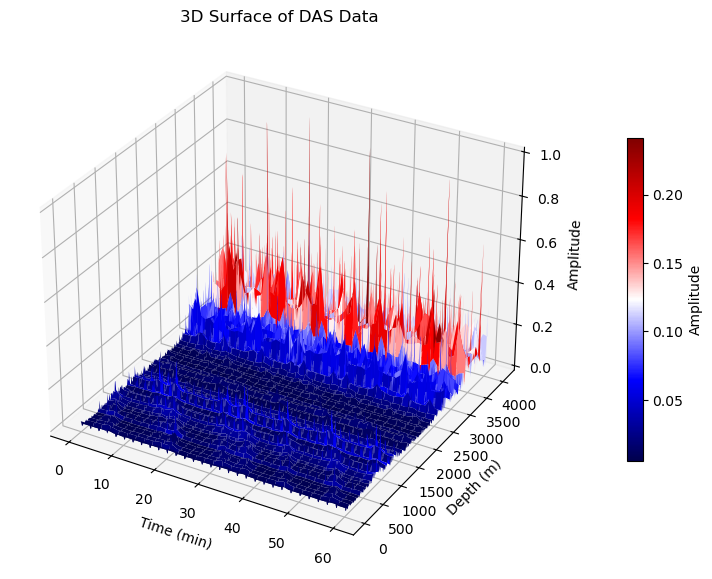

In [25]:
heat_plot(normalize(df, method="minmax"))
space_plot(normalize(df, method="minmax"))

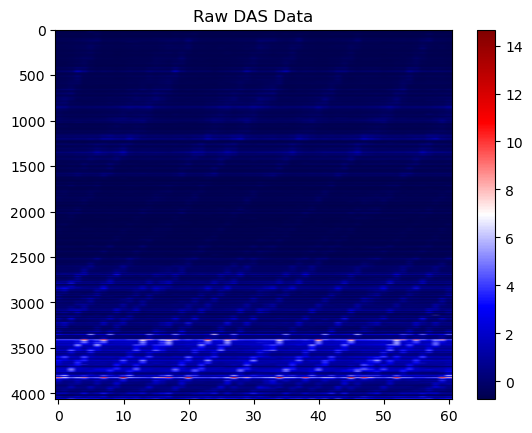

<Figure size 640x480 with 0 Axes>

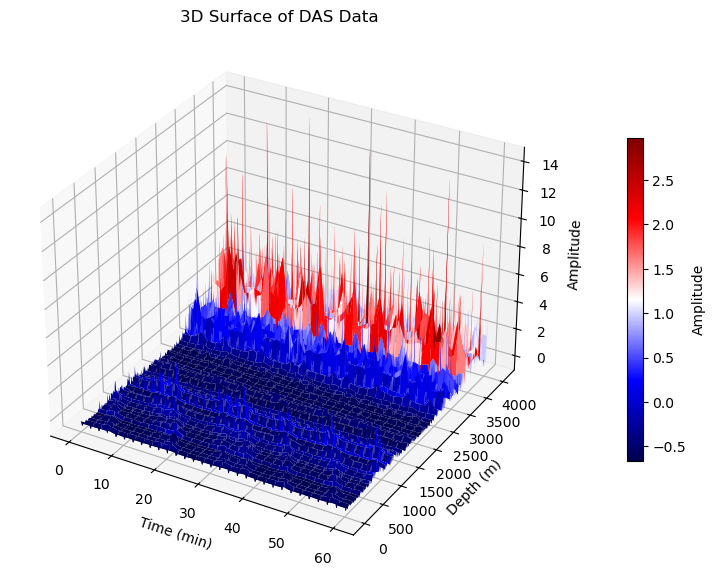

In [28]:
heat_plot(normalize(df, method="global_zscore"))
space_plot(normalize(df, method="global_zscore"))


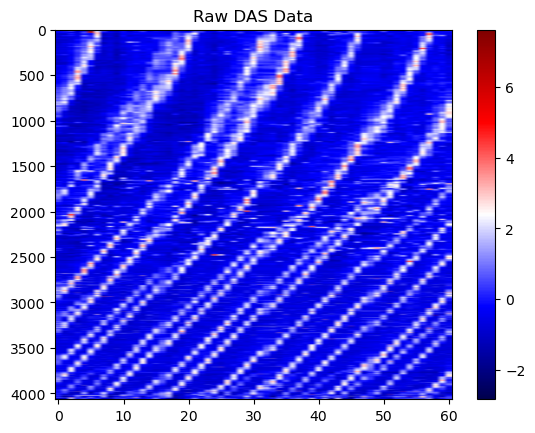

<Figure size 640x480 with 0 Axes>

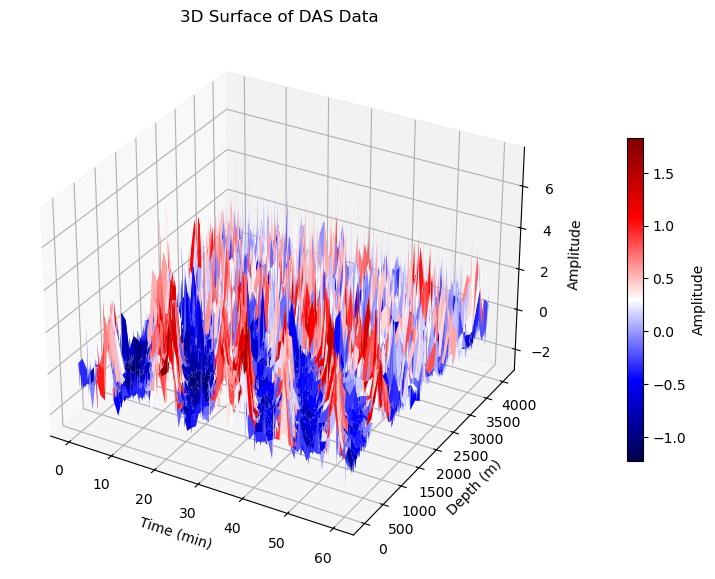

In [29]:
heat_plot(normalize(df, method="row_zscore"))
space_plot(normalize(df, method="row_zscore"))

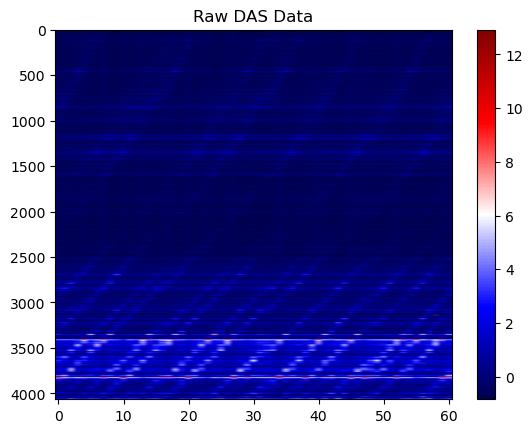

<Figure size 640x480 with 0 Axes>

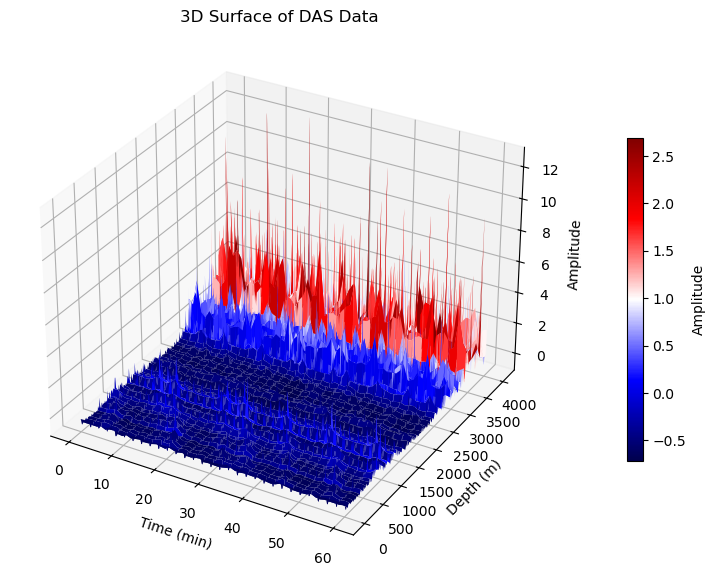

In [30]:
heat_plot(normalize(df, method="col_zscore"))
space_plot(normalize(df, method="col_zscore"))

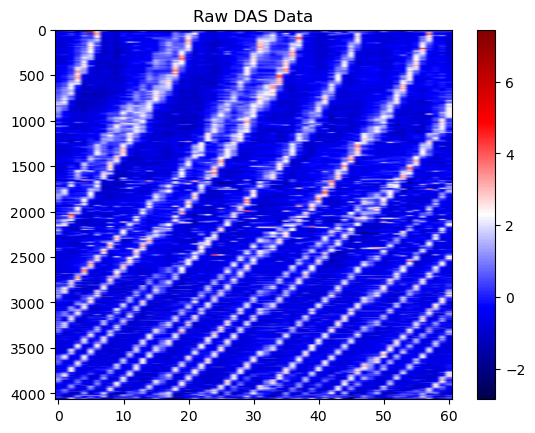

<Figure size 640x480 with 0 Axes>

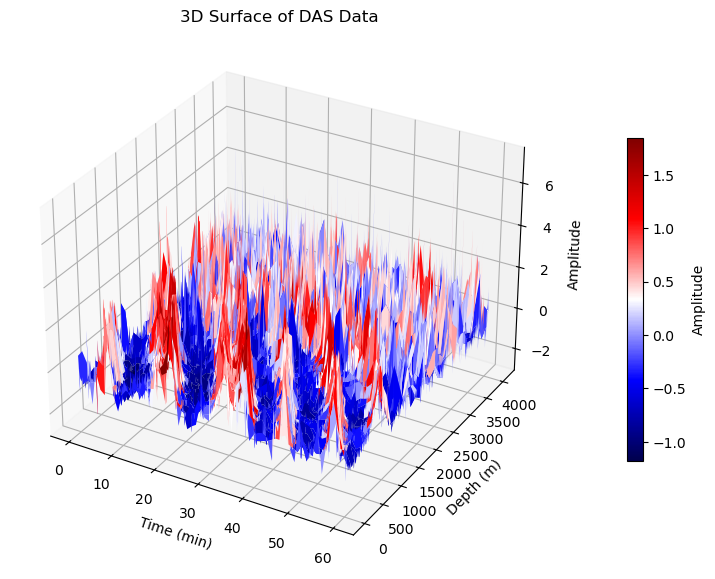

In [32]:
heat_plot(normalize(df, method="detrend_row_zscore"))
space_plot(normalize(df, method="detrend_row_zscore"))

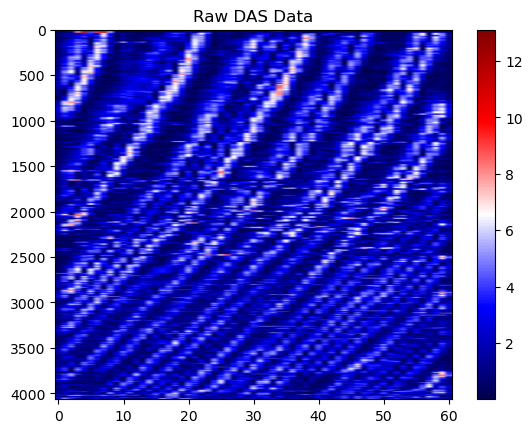

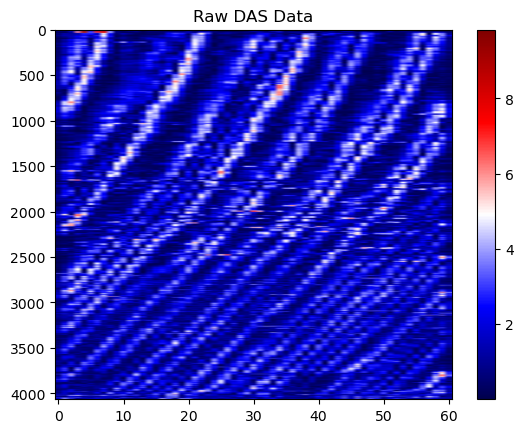

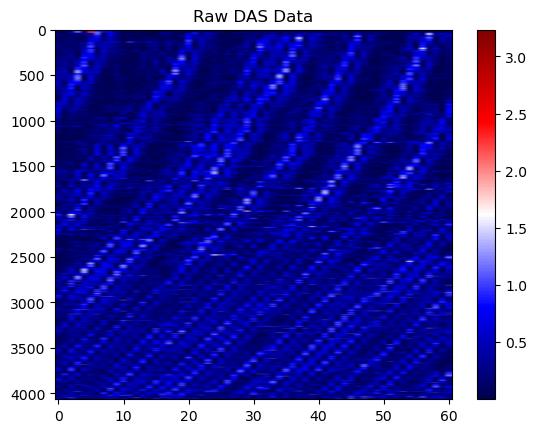

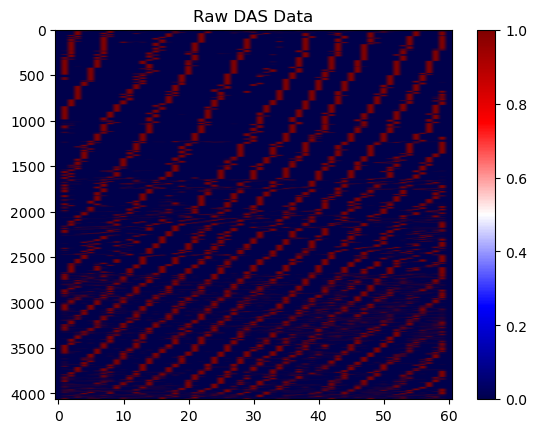

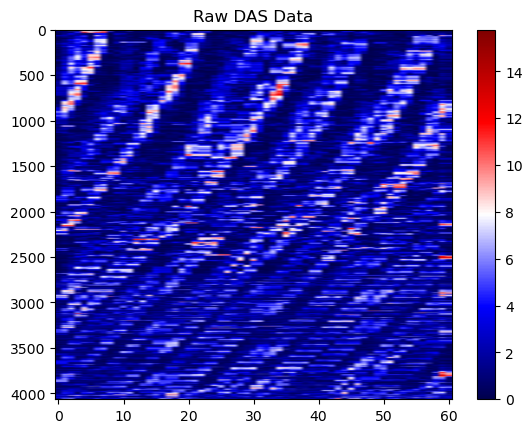

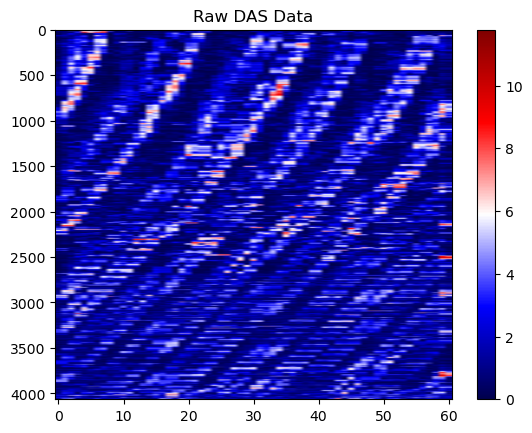

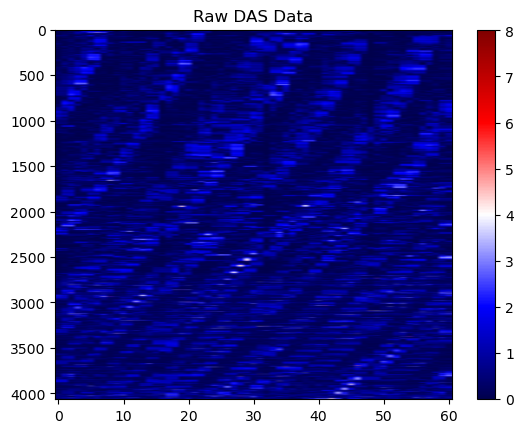

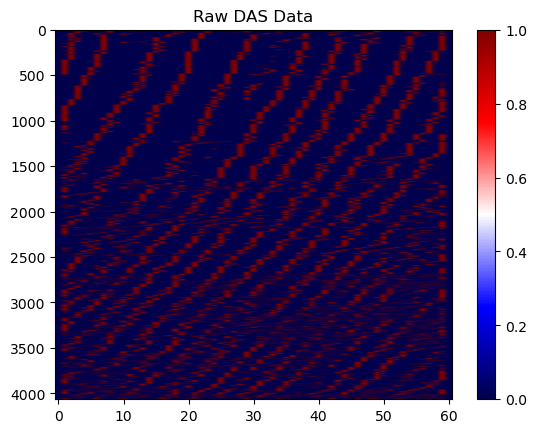

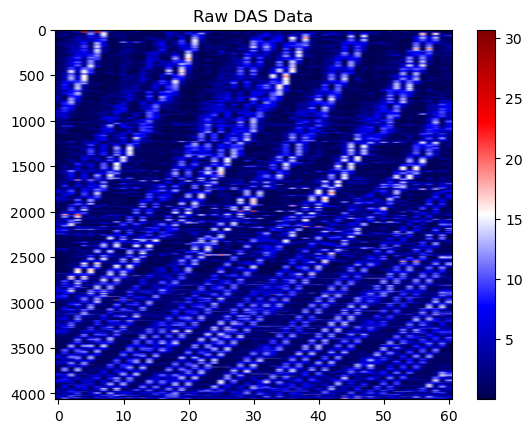

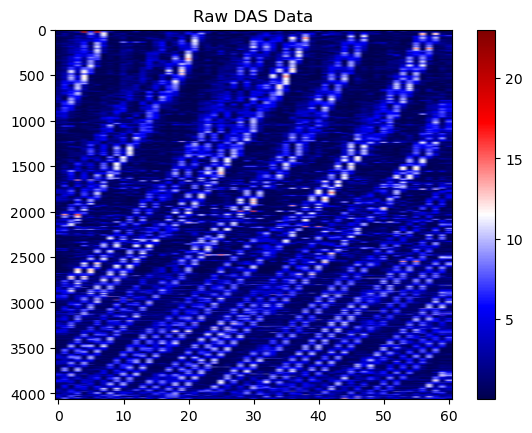

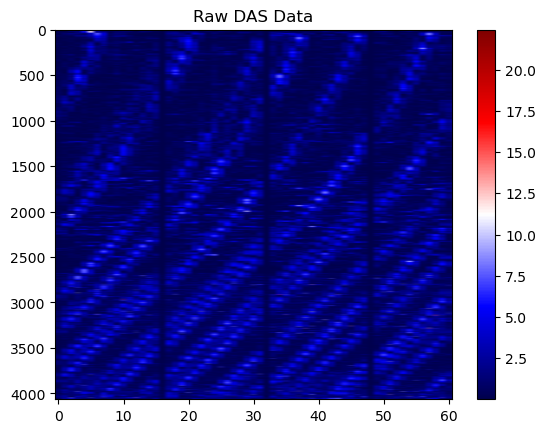

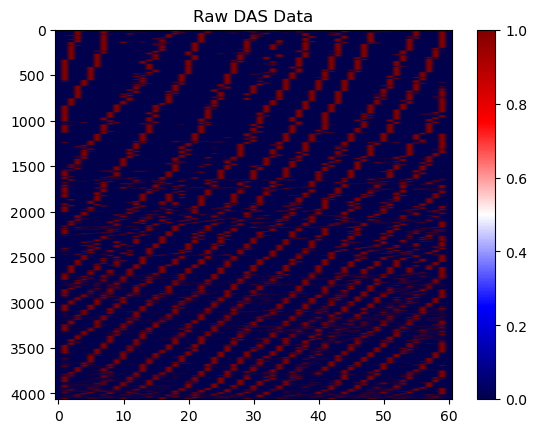

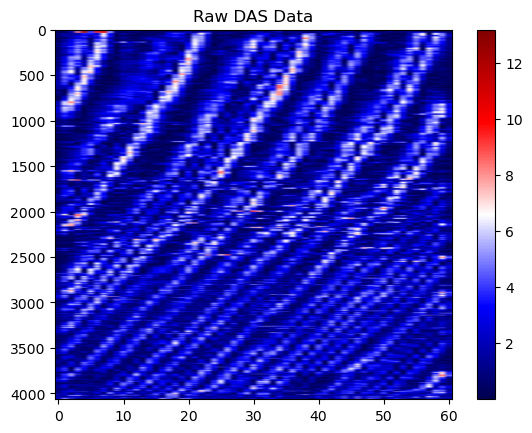

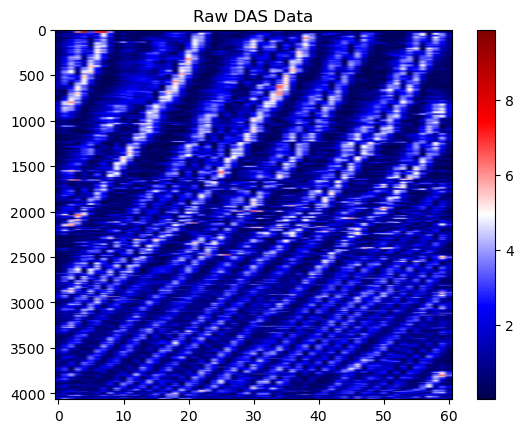

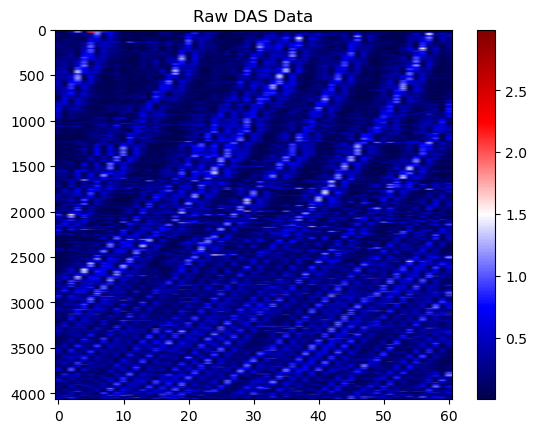

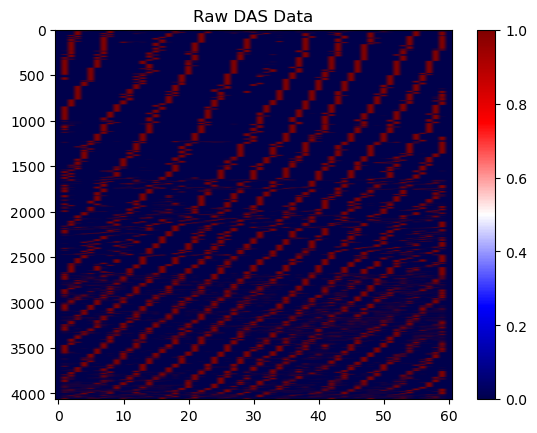

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd

NORMALIZE_METHODS = [
    "row_zscore",
]

NOISE_METHODS = [
    "gaussian",
    "median",
    "detrend",
    "gaussian_detrend",
]

EDGE_METHODS = [
    "sobel",
    "prewitt",
    "laplacian",
    "canny",
]

def run_all_combinations(
    df,
    normalize_methods=NORMALIZE_METHODS,
    noise_methods=NOISE_METHODS,
    edge_methods=EDGE_METHODS,
    gaussian_sigma=(1, 1),
    median_size=(3, 3),
    canny_sigma=2,
    detrend_axis=1,
):
    results = {}  
    for n_method in normalize_methods:
        x1 = normalize(df, method=n_method)

        for nr_method in noise_methods:
            if nr_method == "gaussian":
                x2 = noise_reduction(x1, method=nr_method, sigma=gaussian_sigma)
            elif nr_method == "median":
                x2 = noise_reduction(x1, method=nr_method, size=median_size)
            elif nr_method == "detrend":
                x2 = noise_reduction(x1, method=nr_method, axis=detrend_axis)
            elif nr_method == "gaussian_detrend":
                x2 = noise_reduction(x1, method=nr_method, sigma=gaussian_sigma)
            else:
                raise ValueError(f"Unexpected noise method: {nr_method}")

            for e_method in edge_methods:
                if e_method == "canny":
                    x3 = edge_detection(x2, method=e_method, sigma=canny_sigma)
                else:
                    x3 = edge_detection(x2, method=e_method)

                results[(n_method, nr_method, e_method)] = x3

    return results

results = run_all_combinations(df)

heat_plot(results[("row_zscore", "gaussian", "sobel")])
heat_plot(results[("row_zscore", "gaussian", "prewitt")])
heat_plot(results[("row_zscore", "gaussian", "laplacian")])
heat_plot(results[("row_zscore", "gaussian", "canny")])
heat_plot(results[("row_zscore", "median", "sobel")])
heat_plot(results[("row_zscore", "median", "prewitt")])
heat_plot(results[("row_zscore", "median", "laplacian")])
heat_plot(results[("row_zscore", "median", "canny")])
heat_plot(results[("row_zscore", "detrend", "sobel")])
heat_plot(results[("row_zscore", "detrend", "prewitt")])
heat_plot(results[("row_zscore", "detrend", "laplacian")])
heat_plot(results[("row_zscore", "detrend", "canny")])
heat_plot(results[("row_zscore", "gaussian_detrend", "sobel")])
heat_plot(results[("row_zscore", "gaussian_detrend", "prewitt")])
heat_plot(results[("row_zscore", "gaussian_detrend", "laplacian")])
heat_plot(results[("row_zscore", "gaussian_detrend", "canny")])

In [34]:
def _draw_hough_lines(ax, shape, lines, lw=2):
    H, W = shape
    for ln in lines:
        theta = ln["params"]["theta"]
        rho   = ln["params"]["rho"]
        c, s = np.cos(theta), np.sin(theta)

        pts = []
        if abs(s) > 1e-12:
            y0 = (rho - 0*c) / s
            y1 = (rho - (W-1)*c) / s
            if 0 <= y0 <= H-1: pts.append((0, y0))
            if 0 <= y1 <= H-1: pts.append((W-1, y1))
        if abs(c) > 1e-12:
            x0 = (rho - 0*s) / c
            x1 = (rho - (H-1)*s) / c
            if 0 <= x0 <= W-1: pts.append((x0, 0))
            if 0 <= x1 <= W-1: pts.append((x1, H-1))

        if len(pts) >= 2:
            (xA, yA), (xB, yB) = pts[0], pts[1]
            ax.plot([xA, xB], [yA, yB], linewidth=lw)  

In [14]:
def _draw_ransac_lines(ax, shape, lines, lw=2):
    H, W = shape
    for ln in lines:
        (x0, y0) = ln["params"]["point"]
        (dx, dy) = ln["params"]["direction"]

        pts = []

        if abs(dx) > 1e-12:
            t = (0.0 - x0) / dx
            y = y0 + t * dy
            if 0 <= y <= H - 1:
                pts.append((0.0, y))

            t = ((W - 1.0) - x0) / dx
            y = y0 + t * dy
            if 0 <= y <= H - 1:
                pts.append((W - 1.0, y))

        # y = 0 and y = H-1
        if abs(dy) > 1e-12:
            t = (0.0 - y0) / dy
            x = x0 + t * dx
            if 0 <= x <= W - 1:
                pts.append((x, 0.0))

            t = ((H - 1.0) - y0) / dy
            x = x0 + t * dx
            if 0 <= x <= W - 1:
                pts.append((x, H - 1.0))

        if len(pts) >= 2:
            (xA, yA), (xB, yB) = pts[0], pts[1]
            ax.plot([xA, xB], [yA, yB], linewidth=lw) 

In [15]:
def pipeline_oneplot(
    data,
    norm=("row_zscore", {}),
    noise=(None, {}),
    edge=(None, {}),
    detectors=("hough", "ransac"),
    hough={
        "theta": None,
        "num_peaks": 10,
        "peak_threshold": None,
        "threshold": None,
    },
    ransac={
        "threshold": None,
        "percentile": 98.0,
        "max_points": 50000,
        "min_samples": 2,
        "residual_threshold": 1.5,
        "max_trials": 2000,
        "min_inliers": 250,
        "num_peaks": 6,
        "random_state": 0,
    },
    show="edge", 
):
    x = data
    if norm and norm[0]:
        x = normalize(x, method=norm[0], **(norm[1] or {}))
    if noise and noise[0]:
        x = noise_reduction(x, method=noise[0], **(noise[1] or {}))

    if edge and edge[0]:
        e = edge_detection(x, method=edge[0], **(edge[1] or {}))
    else:
        e = np.asarray(x, dtype=float)

    all_lines = []

    detectors_set = set(detectors) if isinstance(detectors, (list, tuple, set)) else {str(detectors)}

    if "hough" in detectors_set:
        lines_h = _hough_lines(
            e,
            theta=hough.get("theta", None),
            num_peaks=hough.get("num_peaks", 10),
            peak_threshold=hough.get("peak_threshold", None),
            threshold=hough.get("threshold", None),
        )
        all_lines.extend(lines_h)

    if "ransac" in detectors_set:
        lines_r = _ransac_lines(
            e,
            threshold=ransac.get("threshold", None),
            percentile=ransac.get("percentile", 98.0),
            max_points=ransac.get("max_points", 50000),
            min_samples=ransac.get("min_samples", 2),
            residual_threshold=ransac.get("residual_threshold", 1.5),
            max_trials=ransac.get("max_trials", 2000),
            min_inliers=ransac.get("min_inliers", 250),
            num_peaks=ransac.get("num_peaks", 6),
            random_state=ransac.get("random_state", 0),
        )
        all_lines.extend(lines_r)

    bg = e if show == "edge" else np.asarray(x, dtype=float)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(bg, aspect="auto", cmap="seismic")
    ax.set_title(f"{show} + line detectors ({', '.join(sorted(detectors_set))}) | n={len(all_lines)}")

    if "hough" in detectors_set:
        _draw_hough_lines(ax, bg.shape, [ln for ln in all_lines if ln.get("method") == "hough"], lw=2)
    if "ransac" in detectors_set:
        _draw_ransac_lines(ax, bg.shape, [ln for ln in all_lines if ln.get("method") == "ransac"], lw=2)

    plt.show()
    plt.close(fig)

    return e, all_lines

In [ ]:
def velocities_from_lines(lines, dz_m_per_row=1.0, dt_min_per_col=1.0):
    v = []
    for ln in lines:
        m = float(ln.get("slope_dt", np.nan))  
        v_m_per_min = m * (dz_m_per_row / dt_min_per_col)
        v.append({
            "method": ln.get("method"),
            "score": ln.get("score"),
            "slope_rows_per_col": m,
            "v_m_per_min": v_m_per_min,
            "v_m_per_s": v_m_per_min / 60.0,
        })
    return v

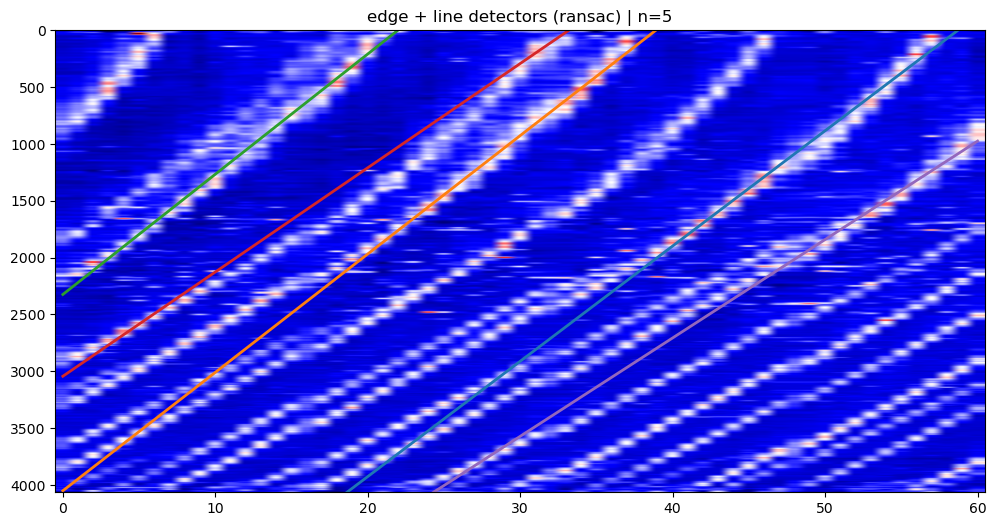

{'method': 'ransac', 'score': 772.0, 'slope_rows_per_col': -101.43093317839998, 'v_m_per_min': -101.43093317839998, 'v_m_per_s': -1.6905155529733331}
{'method': 'ransac', 'score': 663.0, 'slope_rows_per_col': -104.17402745428817, 'v_m_per_min': -104.17402745428817, 'v_m_per_s': -1.7362337909048027}
{'method': 'ransac', 'score': 405.0, 'slope_rows_per_col': -105.78583266426635, 'v_m_per_min': -105.78583266426635, 'v_m_per_s': -1.7630972110711058}
{'method': 'ransac', 'score': 382.0, 'slope_rows_per_col': -91.71864487516488, 'v_m_per_min': -91.71864487516488, 'v_m_per_s': -1.528644081252748}
{'method': 'ransac', 'score': 319.0, 'slope_rows_per_col': -86.58033098930521, 'v_m_per_min': -86.58033098930521, 'v_m_per_s': -1.4430055164884201}


In [ ]:
theta = np.linspace(-np.pi / 8, np.pi / 8, 360)

edge_img, lines = pipeline_oneplot(
    df,
    norm=("row_zscore", {}),
    noise=("gaussian", {"sigma": (3, 0)}),
    edge=(None, {}),
    detectors=("ransac"),
    ransac={
        "percentile": 98.5,
        "max_points": 60000,
        "residual_threshold": 1.25,
        "min_inliers": 250,
        "num_peaks": 6,
        "random_state": 0,
    },
    show="edge",
)

vels = velocities_from_lines(lines, dz_m_per_row=1.0, dt_min_per_col=1.0)
for vel in vels:
    print(vel)

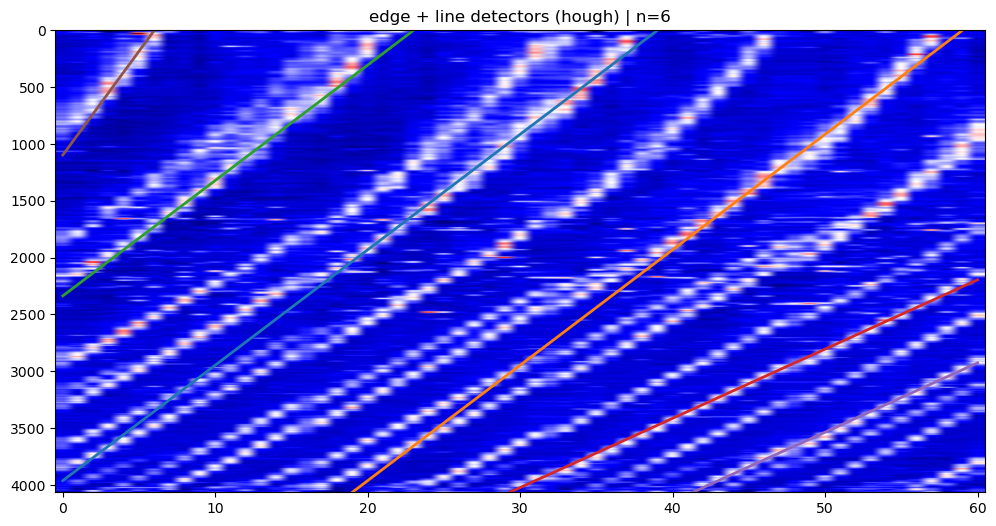

{'method': 'hough', 'score': 1050.0, 'slope_rows_per_col': -101.57293981831486, 'v_m_per_min': -101.57293981831486, 'v_m_per_s': -1.6928823303052478}
{'method': 'hough', 'score': 855.0, 'slope_rows_per_col': -101.57293981831486, 'v_m_per_min': -101.57293981831486, 'v_m_per_s': -1.6928823303052478}
{'method': 'hough', 'score': 506.0, 'slope_rows_per_col': -101.57293981831486, 'v_m_per_min': -101.57293981831486, 'v_m_per_s': -1.6928823303052478}
{'method': 'hough', 'score': 488.0, 'slope_rows_per_col': -60.94026342623285, 'v_m_per_min': -60.94026342623285, 'v_m_per_s': -1.015671057103881}
{'method': 'hough', 'score': 362.0, 'slope_rows_per_col': -60.94026342623285, 'v_m_per_min': -60.94026342623285, 'v_m_per_s': -1.015671057103881}
{'method': 'hough', 'score': 334.0, 'slope_rows_per_col': -182.83537547139252, 'v_m_per_min': -182.83537547139252, 'v_m_per_s': -3.047256257856542}


In [ ]:
theta = np.linspace(-np.pi / 8, np.pi / 8, 360)
edge_img_h, lines_h = pipeline_oneplot(
    df,
    norm=("row_zscore", {}),
    noise=("gaussian", {"sigma": (3, 0)}),
    edge=(None, {}),
    detectors=("hough",),
    hough={
        "theta": theta,
        "num_peaks": 6,
        "peak_threshold": 0,
    },
    show="edge",
)

vels_h = velocities_from_lines(lines_h, dz_m_per_row=1.0, dt_min_per_col=1.0)
for vel in vels_h:
    print(vel)